# Tensorpack tutorial by Pamo
#### In this tutorial, we are going to cover following steps.
* **Data Loading** (Dataflow)
* **Build a model**
* **Training & test** (CPU, GPU, or MultiGPU)
* **Trasfer learning** (Loading a saved Model and training it agiain)
* **Evaluation** (Loading a saved Model and test it)

#### You can find more specific explanations per function in [here](https://tensorpack.readthedocs.io/modules/index.html).

In [1]:
import cv2 # for using AugmentImageComponent
import multiprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorpack import *
from tensorpack.dataflow import *
from tensorpack.tfutils import summary
#from tensorpack.utils.stats import RatioCounter

/Users/chaeujeong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/chaeujeong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/chaeujeong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/chaeujeong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/chaeujeong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: nump

삼항연산자

In [10]:
is_train = 'test'

In [11]:
bool_is_train = is_train == 'train'

In [12]:
bool_is_train

False

## 1. Get DataFlow

In [2]:
def get_dataflow(batch_size, is_train='train'): # str type
    # bool_is_train = is_train == 'train' : 우리는 T/F로 코딩을 하는 경우가 많다. 
    df = dataset.Mnist(is_train, shuffle=True) # return type: dataflow(df)

    # ----- Image Augmentation Options -------- #
    if is_train is 'train':
        augs = [
            #   imgaug.CenterCrop(256, 256),
            #   imgaug.Resize((225, 225)),
            #   imgaug.Grayscale(keepdims=True),
#                imgaug.Flip(horiz=True, vert=False, prob=0.5),
        ]
    else:
        augs = [
            #   imgaug.CenterCrop(256, 256),
            #   imgaug.Resize((225, 225)),
        ]
    df = AugmentImageComponent(df, augs)
    # group data into batches of size 128
    df = BatchData(df, batch_size)
    # start 3 processes to run the dataflow in parallel
    # df = PrefetchDataZMQ(df, 10, multiprocessing.cpu_count())
    return df

### See the data

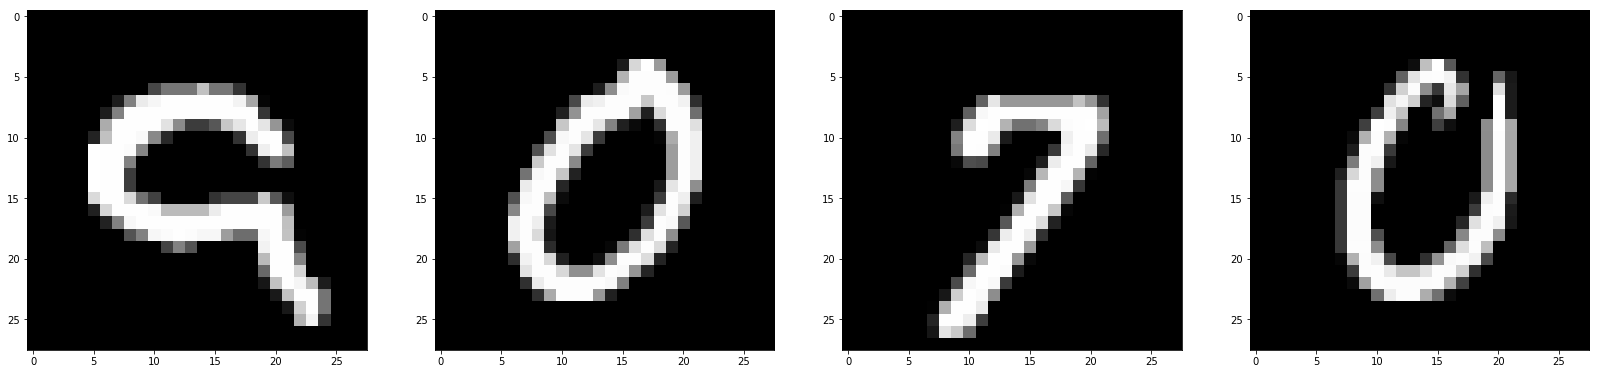

In [4]:
df = get_dataflow(4, 'train') #(batch_size, )
df.reset_state() # 보통 안해줘도 된다. 

fig =plt.figure(figsize=(28, 28))

for idx, dp in enumerate(df.get_data()):
    if idx == 0:
        for i in range(4):
            img = dp[idx][i]
            fig.add_subplot(1, 4, i + 1)
            plt.imshow(img, cmap='gray')
        plt.show()
    break

## 2. Model 
#### Model includes Loss function & Optimizer

In [5]:
# Description of ModelDesc at
# https://tensorpack.readthedocs.io/modules/graph_builder.html#tensorpack.graph_builder.ModelDesc
class Model(ModelDesc):
    def inputs(self):
        """
        Define input shape
        """
        return [tf.placeholder(tf.float32, [None, 28, 28], 'input'),
                tf.placeholder(tf.int32, [None], 'label')]

    def build_graph(self, image, label):
        """
        Build the model which takes the input and return cost. 
        """
        # NHW to NHWC
        image = tf.expand_dims(image, 3)

        with argscope(Conv2D, filters=32, kernel_size=3, activation=tf.nn.relu):
            with tf.name_scope('layer1') as scope:
                layer1 = (LinearWrap(image)
                          .Conv2D('conv0')
                          .MaxPooling('pool0', 2)
                          .Dropout('dropout', rate=0.7)())

        with argscope(Conv2D, filters=64, kernel_size=3, activation=tf.nn.relu):
            with tf.name_scope('layer2') as scope:
                layer2 = (LinearWrap(layer1)
                          .Conv2D('conv1')
                          .MaxPooling('pool1', 2)
                          .Dropout('dropout', rate=0.7)())

        with argscope(Conv2D, filters=128, kernel_size=3, activation=tf.nn.relu):
            with tf.name_scope('layer3') as scope:
                layer3 = (LinearWrap(layer2)
                          .Conv2D('conv2')
                          .MaxPooling('pool2', 2)
                          .Dropout('dropout', rate=0.7)
                          .FullyConnected('fc1', units=10,
                                          activation=tf.identity)())
                
        # Cost function
        cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=layer3, 
                                                           labels=label),
            name='Loss')
        
        correct = tf.cast(tf.equal(tf.argmax(layer3, -1, 
                                             output_type=tf.int32), 
                                   label),
                          tf.float32)
        accuracy = tf.reduce_mean(correct, name='accuracy')
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        
        summary.add_moving_summary(train_error, accuracy) # 이동평균, 그래프를 스무스하게 그려준다. 경향성, 방향성을 파악하기 쉬워진다. 
        return cost

    def optimizer(self):
        lr = tf.train.exponential_decay(
            learning_rate=0.001,
            global_step=get_global_step_var(),
            decay_steps=468 * 10,
            decay_rate=0.3, staircase=True, name='learning_rate')
        # for tensorboard.
        tf.summary.scalar('lr', lr)
        return tf.train.AdamOptimizer(lr)

## 3. main.py
#### `logger` for tensorboard, `TrainConfig` for model configuration including model saver.
* If you use **auto_set_dir()**, it makes a **`'train_log'`** directory and makes another directory in it 
   with the same name of file.py. You can see the scalars with tensorboard at there.

### Tensorboard and datasets 

In [6]:
# for tensorboard 
logger.set_logger_dir('./mnist_result')
# logger.auto_set_dir() : command 창에서 사용, jupyter 에서는 사용불가.

df = get_dataflow(100, 'train')
df_test = get_dataflow(100, 'test')

df.reset_state()
df_test.reset_state()
steps_per_epoch = df.size() # 60000/100

[0814 16:39:11 @logger.py:74] Argv: /Users/chaeujeong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py -f /Users/chaeujeong/Library/Jupyter/runtime/kernel-52a049b8-c364-424a-b72e-76056a78cf1b.json
[0814 16:39:11 @mnist.py:22] Downloading to /Users/chaeujeong/tensorpack_data/mnist_data/t10k-images-idx3-ubyte.gz...


t10k-images-idx3-ubyte.gz: 1.65MB [00:00, 2.18MB/s]                            

[0814 16:39:12 @fs.py:72] Succesfully downloaded t10k-images-idx3-ubyte.gz. 1648877 bytes.


[0814 16:39:12 @mnist.py:22] Downloading to /Users/chaeujeong/tensorpack_data/mnist_data/t10k-labels-idx1-ubyte.gz...


t10k-labels-idx1-ubyte.gz: 8.19kB [00:00, 18.6kB/s]

[0814 16:39:12 @fs.py:72] Succesfully downloaded t10k-labels-idx1-ubyte.gz. 4542 bytes.


### Training

In [7]:
"""
Configuration containing everything necessary in a training.
"""
config = TrainConfig(
    model = Model(),
    data = QueueInput(df), # 상황에 따라서 ZMQ사용도 가능, 
    callbacks = [
        # save the model after every epoch
        ModelSaver(checkpoint_dir='./mnist_result'),
        InferenceRunner(
            df_test,
            ScalarStats(['Loss', 'accuracy'])),
#         ScheduledHyperParamSetter('learning_rate',
#                                   [(1, 0.1), 
#                                    (300, 0.01), 
#                                    (500, 0.001)]) # : 특정 epoch에서 lr을 크게 하거나 줄여라.
    ],
    steps_per_epoch = steps_per_epoch,
    max_epoch = 10,
)

# training with CPU or GPU?
if tf.test.gpu_device_name():
    launch_train_with_config(config, SyncMultiGPUTrainer(4)) # # of GPU
else:
    launch_train_with_config(config, SimpleTrainer())

[0814 16:41:24 @input_source.py:202] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0814 16:41:24 @trainers.py:51] Building graph for a single training tower ...
[0814 16:41:24 @registry.py:121] conv0 input: [None, 28, 28, 1]
[0814 16:41:24 @registry.py:129] conv0 output: [None, 28, 28, 32]
[0814 16:41:24 @registry.py:121] pool0 input: [None, 28, 28, 32]
[0814 16:41:24 @registry.py:129] pool0 output: [None, 14, 14, 32]
[0814 16:41:24 @registry.py:121] conv1 input: [None, 14, 14, 32]
[0814 16:41:24 @registry.py:129] conv1 output: [None, 14, 14, 64]
[0814 16:41:24 @registry.py:121] pool1 input: [None, 14, 14, 64]
[0814 16:41:24 @registry.py:129] pool1 output: [None, 7, 7, 64]
[0814 16:41:24 @registry.py:121] conv2 input: [None, 7, 7, 64]
[0814 16:41:24 @registry.py:129] conv2 output: [None, 7, 7, 128]
[0814 16:41:24 @registry.py:121] pool2 input: [None, 7, 7, 128]
[0814 16:41:24 @registry.py:129] pool2 output: [None, 3, 3, 128]
[0814 16:41:24 @registry.py:121] fc1

100%|##########|600/600[01:26<00:00, 6.95it/s]

[0814 16:42:52 @base.py:260] Epoch 1 (global_step 600) finished, time:1 minute 26 seconds.
[0814 16:42:52 @saver.py:77] Model saved to ./mnist_result/model-600.



100%|##########|100/100[00:04<00:00,22.99it/s]

[0814 16:42:56 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:42:56 @monitor.py:435] accuracy: 0.60853
[0814 16:42:56 @monitor.py:435] lr: 0.001
[0814 16:42:56 @monitor.py:435] train_error: 0.39147
[0814 16:42:56 @monitor.py:435] validation_Loss: 1.021
[0814 16:42:56 @monitor.py:435] validation_accuracy: 0.8394
[0814 16:42:56 @group.py:48] Callbacks took 4.401 sec in total. InferenceRunner: 4.35 seconds
[0814 16:42:56 @base.py:250] Start Epoch 2 ...



100%|##########|600/600[01:31<00:00, 6.96it/s]

[0814 16:44:28 @base.py:260] Epoch 2 (global_step 1200) finished, time:1 minute 31 seconds.
[0814 16:44:28 @saver.py:77] Model saved to ./mnist_result/model-1200.



100%|##########|100/100[00:04<00:00,23.23it/s]

[0814 16:44:32 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:44:32 @monitor.py:435] accuracy: 0.82148
[0814 16:44:32 @monitor.py:435] lr: 0.001
[0814 16:44:32 @monitor.py:435] train_error: 0.17852
[0814 16:44:32 @monitor.py:435] validation_Loss: 0.3877


[0814 16:44:32 @monitor.py:435] validation_accuracy: 0.9302
[0814 16:44:32 @group.py:48] Callbacks took 4.351 sec in total. InferenceRunner: 4.31 seconds
[0814 16:44:32 @base.py:250] Start Epoch 3 ...


100%|##########|600/600[01:32<00:00, 6.19it/s]

[0814 16:46:04 @base.py:260] Epoch 3 (global_step 1800) finished, time:1 minute 32 seconds.
[0814 16:46:04 @saver.py:77] Model saved to ./mnist_result/model-1800.



100%|##########|100/100[00:04<00:00,20.59it/s]

[0814 16:46:09 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:46:09 @monitor.py:435] accuracy: 0.86308
[0814 16:46:09 @monitor.py:435] lr: 0.001
[0814 16:46:09 @monitor.py:435] train_error: 0.13692
[0814 16:46:09 @monitor.py:435] validation_Loss: 0.21717
[0814 16:46:09 @monitor.py:435] validation_accuracy: 0.9609
[0814 16:46:09 @group.py:48] Callbacks took 4.898 sec in total. InferenceRunner: 4.86 seconds
[0814 16:46:09 @base.py:250] Start Epoch 4 ...



100%|##########|600/600[01:34<00:00, 6.32it/s]

[0814 16:47:44 @base.py:260] Epoch 4 (global_step 2400) finished, time:1 minute 34 seconds.
[0814 16:47:44 @saver.py:77] Model saved to ./mnist_result/model-2400.



100%|##########|100/100[00:04<00:00,22.76it/s]

[0814 16:47:49 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:47:49 @monitor.py:435] accuracy: 0.89304
[0814 16:47:49 @monitor.py:435] lr: 0.001
[0814 16:47:49 @monitor.py:435] train_error: 0.10696
[0814 16:47:49 @monitor.py:435] validation_Loss: 0.14566
[0814 16:47:49 @monitor.py:435] validation_accuracy: 0.9696
[0814 16:47:49 @group.py:48] Callbacks took 4.704 sec in total. InferenceRunner: 4.66 seconds
[0814 16:47:49 @base.py:250] Start Epoch 5 ...



100%|##########|600/600[01:36<00:00, 6.21it/s]

[0814 16:49:26 @base.py:260] Epoch 5 (global_step 3000) finished, time:1 minute 36 seconds.
[0814 16:49:26 @saver.py:77] Model saved to ./mnist_result/model-3000.



100%|##########|100/100[00:04<00:00,22.41it/s]

[0814 16:49:30 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:49:30 @monitor.py:435] accuracy: 0.91565
[0814 16:49:30 @monitor.py:435] lr: 0.001
[0814 16:49:30 @monitor.py:435] train_error: 0.084347
[0814 16:49:30 @monitor.py:435] validation_Loss: 0.10987
[0814 16:49:30 @monitor.py:435] validation_accuracy: 0.9775
[0814 16:49:30 @group.py:48] Callbacks took 4.501 sec in total. InferenceRunner: 4.47 seconds
[0814 16:49:30 @base.py:250] Start Epoch 6 ...



100%|##########|600/600[01:27<00:00, 7.27it/s]

[0814 16:50:58 @base.py:260] Epoch 6 (global_step 3600) finished, time:1 minute 27 seconds.
[0814 16:50:58 @saver.py:77] Model saved to ./mnist_result/model-3600.



100%|##########|100/100[00:04<00:00,23.14it/s]

[0814 16:51:02 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:51:02 @monitor.py:435] accuracy: 0.91845
[0814 16:51:02 @monitor.py:435] lr: 0.001
[0814 16:51:02 @monitor.py:435] train_error: 0.081546
[0814 16:51:02 @monitor.py:435] validation_Loss: 0.09271
[0814 16:51:02 @monitor.py:435] validation_accuracy: 0.9806
[0814 16:51:02 @group.py:48] Callbacks took 4.359 sec in total. InferenceRunner: 4.33 seconds


[0814 16:51:02 @base.py:250] Start Epoch 7 ...


100%|##########|600/600[01:36<00:00, 7.33it/s]

[0814 16:52:39 @base.py:260] Epoch 7 (global_step 4200) finished, time:1 minute 36 seconds.
[0814 16:52:39 @saver.py:77] Model saved to ./mnist_result/model-4200.



100%|##########|100/100[00:04<00:00,23.33it/s]

[0814 16:52:43 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:52:43 @monitor.py:435] accuracy: 0.93461
[0814 16:52:43 @monitor.py:435] lr: 0.001
[0814 16:52:43 @monitor.py:435] train_error: 0.065392
[0814 16:52:43 @monitor.py:435] validation_Loss: 0.078173


[0814 16:52:43 @monitor.py:435] validation_accuracy: 0.9829
[0814 16:52:43 @group.py:48] Callbacks took 4.334 sec in total. InferenceRunner: 4.29 seconds
[0814 16:52:43 @base.py:250] Start Epoch 8 ...


100%|##########|600/600[01:31<00:00, 6.53it/s]

[0814 16:54:15 @base.py:260] Epoch 8 (global_step 4800) finished, time:1 minute 31 seconds.
[0814 16:54:15 @saver.py:77] Model saved to ./mnist_result/model-4800.



100%|##########|100/100[00:04<00:00,24.25it/s]

[0814 16:54:19 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:54:19 @monitor.py:435] accuracy: 0.94347
[0814 16:54:19 @monitor.py:435] lr: 0.0003
[0814 16:54:19 @monitor.py:435] train_error: 0.056533
[0814 16:54:19 @monitor.py:435] validation_Loss: 0.070159
[0814 16:54:19 @monitor.py:435] validation_accuracy: 0.9851
[0814 16:54:19 @group.py:48] Callbacks took 4.158 sec in total. InferenceRunner: 4.13 seconds
[0814 16:54:19 @base.py:250] Start Epoch 9 ...



100%|##########|600/600[01:35<00:00, 6.26it/s]

[0814 16:55:55 @base.py:260] Epoch 9 (global_step 5400) finished, time:1 minute 35 seconds.
[0814 16:55:55 @saver.py:77] Model saved to ./mnist_result/model-5400.



100%|##########|100/100[00:05<00:00,19.50it/s]

[0814 16:56:00 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:56:00 @monitor.py:435] accuracy: 0.94025
[0814 16:56:00 @monitor.py:435] lr: 0.0003
[0814 16:56:00 @monitor.py:435] train_error: 0.059746
[0814 16:56:00 @monitor.py:435] validation_Loss: 0.065854
[0814 16:56:00 @monitor.py:435] validation_accuracy: 0.9845
[0814 16:56:00 @group.py:48] Callbacks took 5.183 sec in total. InferenceRunner: 5.14 seconds
[0814 16:56:00 @base.py:250] Start Epoch 10 ...



100%|##########|600/600[01:23<00:00, 7.23it/s]

[0814 16:57:23 @base.py:260] Epoch 10 (global_step 6000) finished, time:1 minute 23 seconds.
[0814 16:57:23 @saver.py:77] Model saved to ./mnist_result/model-6000.



100%|##########|100/100[00:04<00:00,23.21it/s]

[0814 16:57:28 @monitor.py:435] QueueInput/queue_size: 50
[0814 16:57:28 @monitor.py:435] accuracy: 0.94362
[0814 16:57:28 @monitor.py:435] lr: 0.0003


[0814 16:57:28 @monitor.py:435] train_error: 0.056378
[0814 16:57:28 @monitor.py:435] validation_Loss: 0.063275
[0814 16:57:28 @monitor.py:435] validation_accuracy: 0.9854
[0814 16:57:28 @group.py:48] Callbacks took 4.357 sec in total. InferenceRunner: 4.31 seconds
[0814 16:57:28 @base.py:264] Training has finished!
[0814 16:57:28 @input_source.py:157] EnqueueThread QueueInput/input_queue Exited.


## 5. Loading The Saved Model 
#### Loading saved model and learning 5 epochs more.
##### In tensorflow, 
* **`.meta`** file means **the structure** of model, 
    all **variables, and operations.** 
* **`index`** means a binary file contating **weights, biases, and gradients**.

* We are going to use **`PredictConfig`** to evaluate the loaded and more trained model.

### Transfer Learning

In [9]:
config = AutoResumeTrainConfig(
    model = Model(),
    session_init = get_model_loader('./mnist_result/model-6000.index'),
    data = QueueInput(df),
    callbacks = [
        # save the model after every epoch
        ModelSaver(checkpoint_dir='./mnist_result/transfer'),
        InferenceRunner(
            df_test,
            ScalarStats(['Loss', 'accuracy'])),
#         ScheduledHyperParamSetter('learning_rate',
#                                   [(1, 0.1), 
#                                    (300, 0.01), 
#                                    (500, 0.001)])
    ],
    steps_per_epoch = steps_per_epoch,
    max_epoch = 5,
)

launch_train_with_config(config, SimpleTrainer())

[0814 17:00:03 @varmanip.py:182] Checkpoint path ./mnist_result/model-6000.index is auto-corrected to ./mnist_result/model-6000.
[0814 17:00:03 @config.py:215] Found checkpoint at ./mnist_result/model-6000. session_init arguments will be overwritten.
[0814 17:00:03 @config.py:225] Found history statistics from JSON. Overwrite the starting epoch to epoch #11.


RuntimeError: Graph is finalized and cannot be modified.

### Evaluation

In [ ]:
model = Model()
session = get_model_loader('./mnist_result/model-6000.index')

pred_config = PredictConfig(
        model=model,
        session_init=session,
        input_names=['input', 'label'], # class Model-inputs
        output_names=['accuracy', 'Loss'] # class Model-build_graph
    )
pred = SimpleDatasetPredictor(pred_config, df_test)

In [ ]:
accuracy = 0.0
total_loss = 0.0

for i, (acc, loss) in enumerate(pred.get_result()): # 각 batch마다 pred에서 get_result
    accuracy += acc 
    total_loss += loss
    
print("Accuracy: {:0.3f}".format(accuracy/(i+1)))
print("Loss: {:0.3f}".format(total_loss/(i+1)))